# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:08:44.979936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:08:44.979985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:08:44.981469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-1, who has ID: A11OTLEDSW8ZXD

In [2]:
parameters = {}

user = "users-1"
user_id = "A11OTLEDSW8ZXD"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A2N0PM621WLCF9,B00008DFDO,B0140GLSFA,B00339J31W
1,A2N0PM621WLCF9,B000E8OW3Y,B00008DFDO,B004XP506W
2,A2N0PM621WLCF9,B000KBFKIQ,B000E8OW3Y,B005P78ZIM
3,A2V16V9O1JR53A,B000BQN9LA,B00HYN8602,B00Y488TMU
4,A1HNTGAUD22THJ,B00008DFDO,B00S8VEH3E,B0002ASC0S
...,...,...,...,...
79399,A2BJMI5PPO105N,B01HCJP7YK,B000QSLTX8,B014S7DEYO
79400,A2BD3988PIF2KB,B01HHUAQLI,B005J3XIE8,B00JT3S1Q4
79401,A1052U8XMXHQ1I,B01HHUAQLI,B00KC9DAGK,B004OAIZK4
79402,A130VASCDRA6RL,B01HHUAQLI,B003TAWW9A,B01D2SSER2


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset or has no category, based on the encoding dictionary, which contains only products which are in meta dataset and have category

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 79404
Number of sequences and targets after removal: 77941


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A11OTLEDSW8ZXD
productID                 B01EYB3ULG
purchased_before_1        B00J0E30IQ
purchased_before_2        B014UTY5Z2
Name: 564, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 77940
Number of sequences and targets after dropping duplicates: 74916


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 466
Number of unique product IDs in sequences: 28594


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B0140GLSFA', 'B00339J31W'],
        ['B00008DFDO', 'B004XP506W'],
        ['B000E8OW3Y', 'B005P78ZIM'],
        ['B00HYN8602', 'B00Y488TMU'],
        ['B00S8VEH3E', 'B0002ASC0S'],
        ['B0052OUXHO', 'B0026JAKWG'],
        ['B007M0JHGE', 'B001EE5LEQ'],
        ['B01EMZ3JSS', 'B01F0RUQD8'],
        ['B00MNW6REG', 'B00TEGIBTI'],
        ['B00BERPOP4', 'B00008DFDO']], dtype=object),
 array(['B00008DFDO', 'B000E8OW3Y', 'B000KBFKIQ', 'B000BQN9LA',
        'B00008DFDO', 'B00008DFDO', 'B000JJJ7CE', 'B00008DFDO',
        'B00008DFDO', 'B000IZPY3K'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[123506, 32607],
        [400, 41827],
        [10857, 48906],
        [87408, 117698],
        [109205, 3072],
        [43274, 29130],
        [56413, 24084],
        [139715, 140330],
        [99665, 110972],
        [68617, 400]], dtype=object),
 array([400, 10857, 13877, 10328, 400, 400, 13672, 400, 400, 13554],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 59904
Number of validation sequences: 7495
Number of test sequences: 7517

Number of train targets: 59904
Number of validation targets: 7495
Number of test targets: 7517

Number of classes (unique product IDs) in the train targets: 457
Number of classes in the validation targets: 462
Number of classes in the test targets: 466


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([37031, 330], dtype=object),
 array([123506, 32607], dtype=object),
 array([23990, 62499], dtype=object),
 array([8788, 25895], dtype=object),
 array([3245, 3700], dtype=object),
 array([109483, 116779], dtype=object),
 array([89446, 96074], dtype=object),
 array([38329, 64721], dtype=object),
 array([86661, 89402], dtype=object),
 array([47679, 92070], dtype=object)]

In [19]:
y_train[:10]

[362, 400, 400, 400, 400, 400, 400, 400, 400, 400]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
  27/1872 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0905 - f1_score: 0.0694 - f1_score_at_k: 0.1261 - hit_rate_at_k: 0.3424 - loss: 11.8331 - ndcg_at_k: 0.0745                      

I0000 00:00:1714590542.314383    6660 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1872/1872 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.1212 - f1_score: 0.0521 - f1_score_at_k: 0.0949 - hit_rate_at_k: 0.3508 - loss: 7.0997 - ndcg_at_k: 0.0809 - val_accuracy: 0.0407 - val_f1_score: 0.0434 - val_f1_score_at_k: 0.0894 - val_hit_rate_at_k: 0.0912 - val_loss: 5.6873 - val_ndcg_at_k: 0.0227
Epoch 2/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.1439 - f1_score: 0.0706 - f1_score_at_k: 0.1147 - hit_rate_at_k: 0.3616 - loss: 4.1486 - ndcg_at_k: 0.0862 - val_accuracy: 0.0551 - val_f1_score: 0.0579 - val_f1_score_at_k: 0.0996 - val_hit_rate_at_k: 0.0972 - val_loss: 5.6392 - val_ndcg_at_k: 0.0261
Epoch 3/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1532 - f1_score: 0.0823 - f1_score_at_k: 0.1256 - hit_rate_at_k: 0.3701 - loss: 4.0860 - ndcg_at_k: 0.0896 - val_accuracy: 0.0615 - val_f1_score: 0.0677 - val_f1_score_at_k: 0.1181 - val_hit_rate_at_k: 0.1132 - val_loss: 5.7376 - val_ndcg_at_k: 0.0292
Epoch 4/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 11s 6m

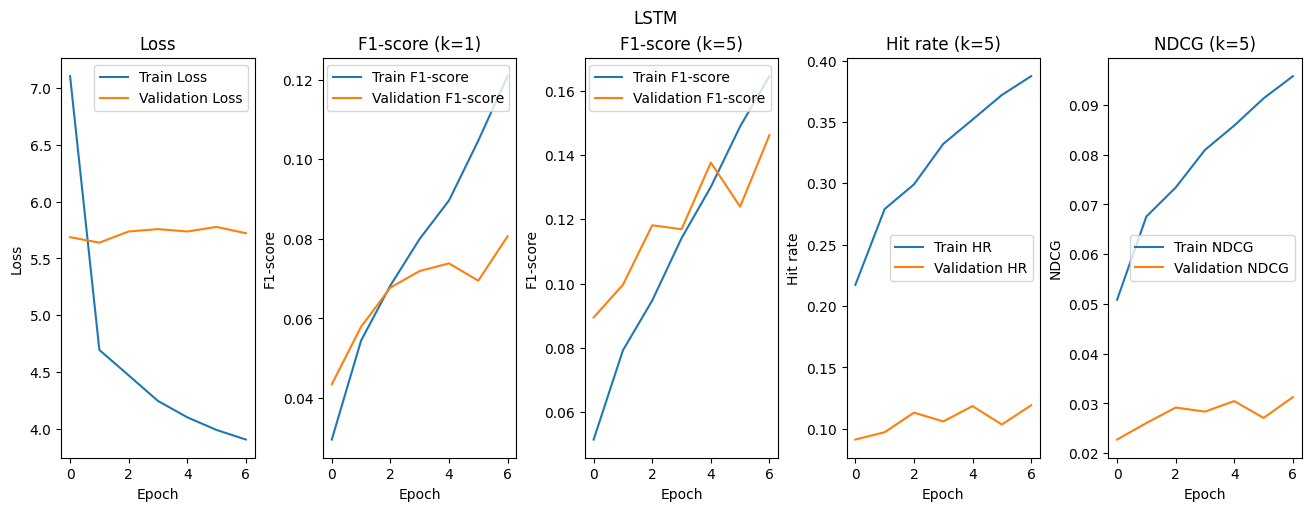

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0414 - f1_score: 0.0491 - f1_score_at_k: 0.0830 - hit_rate_at_k: 0.0643 - loss: 5.9336 - ndcg_at_k: 0.0178       
Test loss: 5.7144
Test accuracy: 0.0636
Test F1@1: 0.0798
Test F1@5: 0.1479
Test HR@5: 0.1206
Test NDCG@5: 0.0314


In [32]:
parameters

{'user': 'users-1',
 'user_id': 'A11OTLEDSW8ZXD',
 'number_of_sequences_and_targets_before_removal': 79404,
 'number_of_sequences_and_targets_after_removal': 77941,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 74916,
 'num_unique_product_ids_in_targets': 466,
 'num_unique_product_ids_in_sequences': 28594,
 'number_of_sequences_and_targets_train': 59904,
 'number_of_sequences_and_targets_validation': 7495,
 'number_of_sequences_and_targets_test': 7517,
 'number_of_unique_products_in_targets_train': 457,
 'number_of_unique_products_in_targets_validation': 462,
 'number_of_unique_products_in_targets_test': 466,
 'model_lstm_test_loss': 5.71441650390625,
 'model_lstm_test_accuracy': 0.0636,
 'model_lstm_test_f1_score_k_1': 0.0798,
 'model_lstm_test_f1_score_k_5': 0.1479,
 'model_lstm_test_hr': 0.1206,
 'model_lstm_test_ndcg': 0.0314}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.1319 - f1_score: 0.0595 - f1_score_at_k: 0.1027 - hit_rate_at_k: 0.3633 - loss: 6.7980 - ndcg_at_k: 0.0850 - val_accuracy: 0.0247 - val_f1_score: 0.0296 - val_f1_score_at_k: 0.0713 - val_hit_rate_at_k: 0.0719 - val_loss: 5.7156 - val_ndcg_at_k: 0.0166
Epoch 2/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1418 - f1_score: 0.0675 - f1_score_at_k: 0.1108 - hit_rate_at_k: 0.3676 - loss: 4.1013 - ndcg_at_k: 0.0871 - val_accuracy: 0.0567 - val_f1_score: 0.0663 - val_f1_score_at_k: 0.1117 - val_hit_rate_at_k: 0.1035 - val_loss: 5.5949 - val_ndcg_at_k: 0.0272
Epoch 3/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1687 - f1_score: 0.0881 - f1_score_at_k: 0.1405 - hit_rate_at_k: 0.4071 - loss: 3.8918 - ndcg_at_k: 0.0984 - val_accuracy: 0.0718 - val_f1_score: 0.0848 - val_f1_score_at_k: 0.1361 - val_hit_rate_at_k: 0.1229 - val_loss: 5.6450 - val_ndcg_at_k: 0.0332
Epoch 4/50
1872/1872 ━━━━━━━━━━━━━━━━

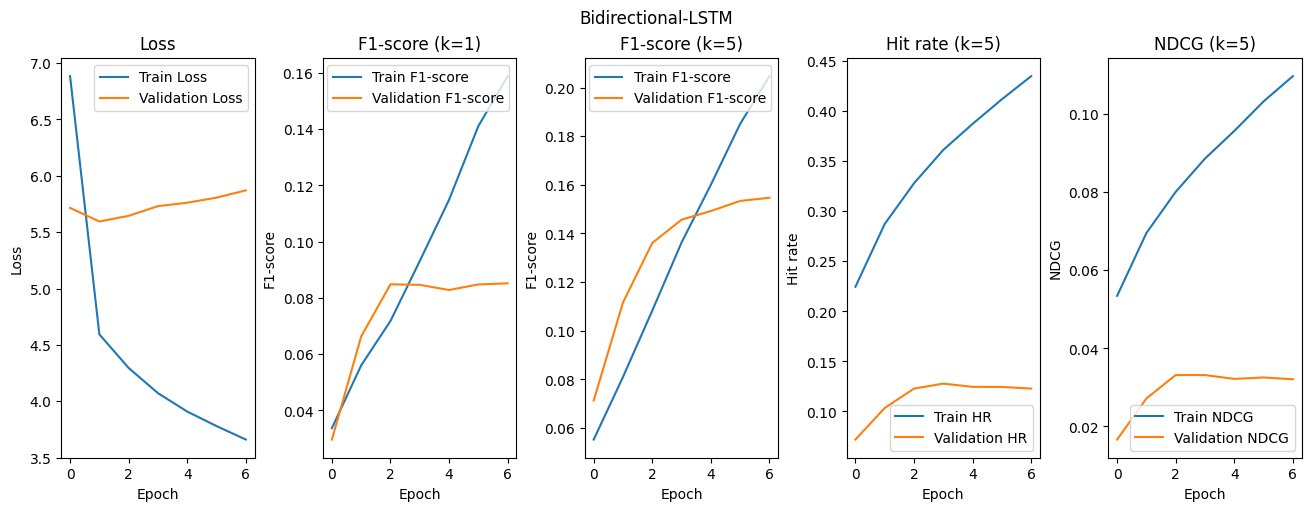

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.0397 - f1_score: 0.0486 - f1_score_at_k: 0.0774 - hit_rate_at_k: 0.0607 - loss: 6.2458 - ndcg_at_k: 0.0171    
Test loss: 5.8763
Test accuracy: 0.0676
Test F1@1: 0.0889
Test F1@5: 0.1536
Test HR@5: 0.1205
Test NDCG@5: 0.0321


In [37]:
parameters

{'user': 'users-1',
 'user_id': 'A11OTLEDSW8ZXD',
 'number_of_sequences_and_targets_before_removal': 79404,
 'number_of_sequences_and_targets_after_removal': 77941,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 74916,
 'num_unique_product_ids_in_targets': 466,
 'num_unique_product_ids_in_sequences': 28594,
 'number_of_sequences_and_targets_train': 59904,
 'number_of_sequences_and_targets_validation': 7495,
 'number_of_sequences_and_targets_test': 7517,
 'number_of_unique_products_in_targets_train': 457,
 'number_of_unique_products_in_targets_validation': 462,
 'number_of_unique_products_in_targets_test': 466,
 'model_lstm_test_loss': 5.71441650390625,
 'model_lstm_test_accuracy': 0.0636,
 'model_lstm_test_f1_score_k_1': 0.0798,
 'model_lstm_test_f1_score_k_5': 0.1479,
 'model_lstm_test_hr': 0.1206,
 'model_lstm_test_ndcg': 0.0314,
 'model_bi_lstm_test_loss': 5.876297950744629,
 'model_bi_lstm_test_accuracy': 0.0676,
 'model_bi_lstm_test_f1_score_k_1': 0.0

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.1274 - f1_score: 0.0567 - f1_score_at_k: 0.0950 - hit_rate_at_k: 0.3542 - loss: 7.1321 - ndcg_at_k: 0.0827 - val_accuracy: 0.0334 - val_f1_score: 0.0367 - val_f1_score_at_k: 0.1108 - val_hit_rate_at_k: 0.1072 - val_loss: 5.7569 - val_ndcg_at_k: 0.0236
Epoch 2/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.1307 - f1_score: 0.0593 - f1_score_at_k: 0.1012 - hit_rate_at_k: 0.3532 - loss: 4.1658 - ndcg_at_k: 0.0828 - val_accuracy: 0.0447 - val_f1_score: 0.0542 - val_f1_score_at_k: 0.0948 - val_hit_rate_at_k: 0.0910 - val_loss: 5.6441 - val_ndcg_at_k: 0.0230
Epoch 3/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.1511 - f1_score: 0.0791 - f1_score_at_k: 0.1241 - hit_rate_at_k: 0.3734 - loss: 4.0746 - ndcg_at_k: 0.0894 - val_accuracy: 0.0426 - val_f1_score: 0.0510 - val_f1_score_at_k: 0.1012 - val_hit_rate_at_k: 0.0916 - val_loss: 5.7304 - val_ndcg_at_k: 0.0232
Epoch 4/50
1872/1872 ━━━━━━━━━━━━━━━━

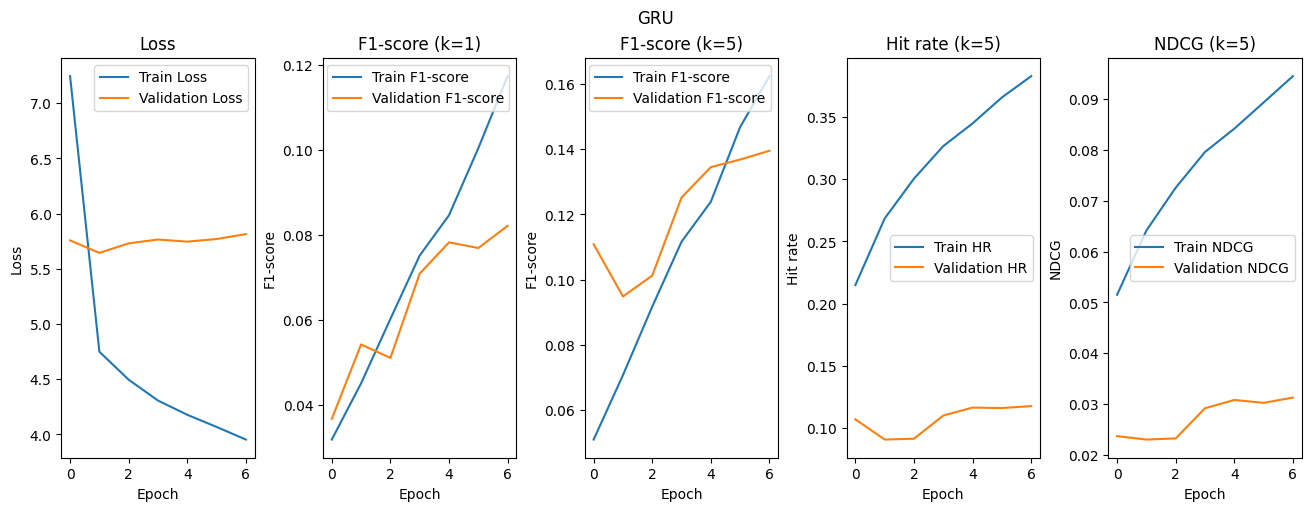

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0383 - f1_score: 0.0457 - f1_score_at_k: 0.0600 - hit_rate_at_k: 0.0511 - loss: 6.1271 - ndcg_at_k: 0.0152        
Test loss: 5.8109
Test accuracy: 0.0639
Test F1@1: 0.0807
Test F1@5: 0.1355
Test HR@5: 0.1134
Test NDCG@5: 0.0303


In [42]:
parameters

{'user': 'users-1',
 'user_id': 'A11OTLEDSW8ZXD',
 'number_of_sequences_and_targets_before_removal': 79404,
 'number_of_sequences_and_targets_after_removal': 77941,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 74916,
 'num_unique_product_ids_in_targets': 466,
 'num_unique_product_ids_in_sequences': 28594,
 'number_of_sequences_and_targets_train': 59904,
 'number_of_sequences_and_targets_validation': 7495,
 'number_of_sequences_and_targets_test': 7517,
 'number_of_unique_products_in_targets_train': 457,
 'number_of_unique_products_in_targets_validation': 462,
 'number_of_unique_products_in_targets_test': 466,
 'model_lstm_test_loss': 5.71441650390625,
 'model_lstm_test_accuracy': 0.0636,
 'model_lstm_test_f1_score_k_1': 0.0798,
 'model_lstm_test_f1_score_k_5': 0.1479,
 'model_lstm_test_hr': 0.1206,
 'model_lstm_test_ndcg': 0.0314,
 'model_bi_lstm_test_loss': 5.876297950744629,
 'model_bi_lstm_test_accuracy': 0.0676,
 'model_bi_lstm_test_f1_score_k_1': 0.0

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.1108 - f1_score: 0.0632 - f1_score_at_k: 0.1051 - hit_rate_at_k: 0.2710 - loss: 8.3959 - ndcg_at_k: 0.0648 - val_accuracy: 0.0374 - val_f1_score: 0.0392 - val_f1_score_at_k: 0.0875 - val_hit_rate_at_k: 0.0834 - val_loss: 6.9414 - val_ndcg_at_k: 0.0207
Epoch 2/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1343 - f1_score: 0.0694 - f1_score_at_k: 0.1138 - hit_rate_at_k: 0.3505 - loss: 4.4772 - ndcg_at_k: 0.0829 - val_accuracy: 0.0376 - val_f1_score: 0.0423 - val_f1_score_at_k: 0.1008 - val_hit_rate_at_k: 0.0948 - val_loss: 6.5454 - val_ndcg_at_k: 0.0226
Epoch 3/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1450 - f1_score: 0.0752 - f1_score_at_k: 0.1212 - hit_rate_at_k: 0.3745 - loss: 4.2489 - ndcg_at_k: 0.0889 - val_accuracy: 0.0423 - val_f1_score: 0.0524 - val_f1_score_at_k: 0.1118 - val_hit_rate_at_k: 0.1007 - val_loss: 6.3040 - val_ndcg_at_k: 0.0246
Epoch 4/50
1872/1872 ━━━━━━━━━━━━━━━━

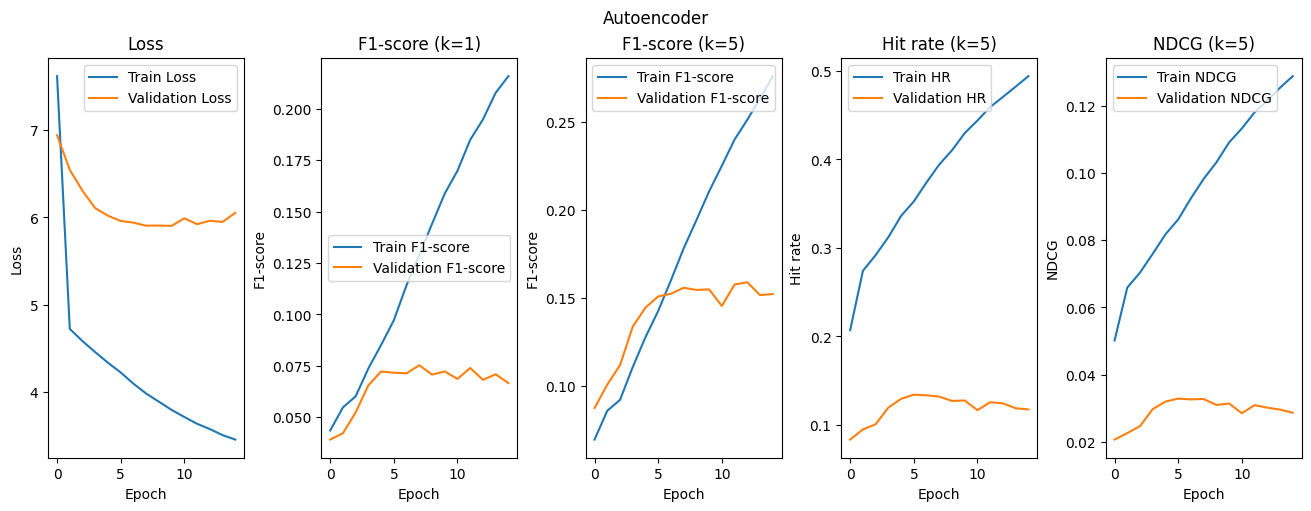

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0151 - f1_score: 0.0212 - f1_score_at_k: 0.0822 - hit_rate_at_k: 0.0628 - loss: 6.2934 - ndcg_at_k: 0.0139      
Test loss: 6.0406
Test accuracy: 0.0514
Test F1@1: 0.0711
Test F1@5: 0.155
Test HR@5: 0.1199
Test NDCG@5: 0.0297


In [47]:
parameters

{'user': 'users-1',
 'user_id': 'A11OTLEDSW8ZXD',
 'number_of_sequences_and_targets_before_removal': 79404,
 'number_of_sequences_and_targets_after_removal': 77941,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 74916,
 'num_unique_product_ids_in_targets': 466,
 'num_unique_product_ids_in_sequences': 28594,
 'number_of_sequences_and_targets_train': 59904,
 'number_of_sequences_and_targets_validation': 7495,
 'number_of_sequences_and_targets_test': 7517,
 'number_of_unique_products_in_targets_train': 457,
 'number_of_unique_products_in_targets_validation': 462,
 'number_of_unique_products_in_targets_test': 466,
 'model_lstm_test_loss': 5.71441650390625,
 'model_lstm_test_accuracy': 0.0636,
 'model_lstm_test_f1_score_k_1': 0.0798,
 'model_lstm_test_f1_score_k_5': 0.1479,
 'model_lstm_test_hr': 0.1206,
 'model_lstm_test_ndcg': 0.0314,
 'model_bi_lstm_test_loss': 5.876297950744629,
 'model_bi_lstm_test_accuracy': 0.0676,
 'model_bi_lstm_test_f1_score_k_1': 0.0

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A11OTLEDSW8ZXD', 'sequence': [90069, 124820], 'target': 140245}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 0.0
NDCG@50: 0.0
-------------
HT@100: 0.0
NDCG@100: 0.0
-------------
HT@200: 0.0
NDCG@200: 0.0
-------------
HT@300: 1.0
NDCG@300: 0.0026714105624705553
-------------
HT@400: 1.0
NDCG@400: 0.0021375445649027824
-------------
HT@500: 1.0
NDCG@500: 0.0017938510281965137
-------------
